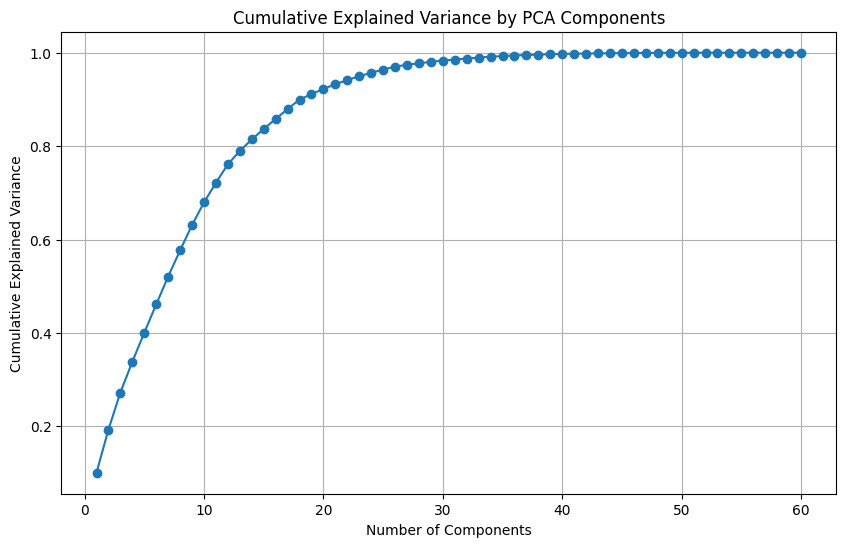

Selected 24 components to retain at least 95% of the variance.
Threshold score at 90.0% percentile: 0.47


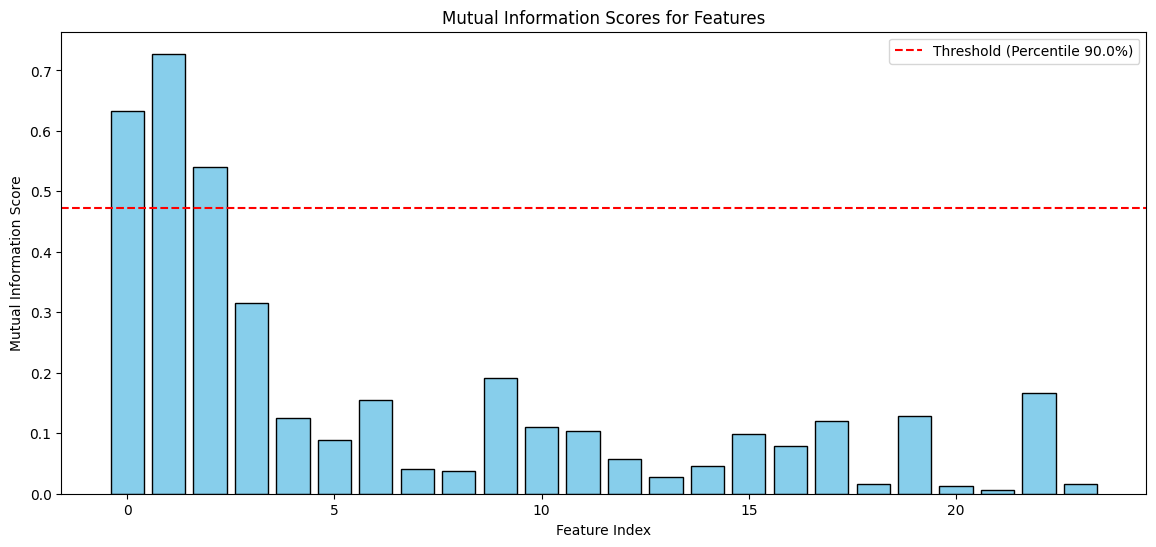

Selected feature indices: [0, 1, 2]
Number of selected features: 3


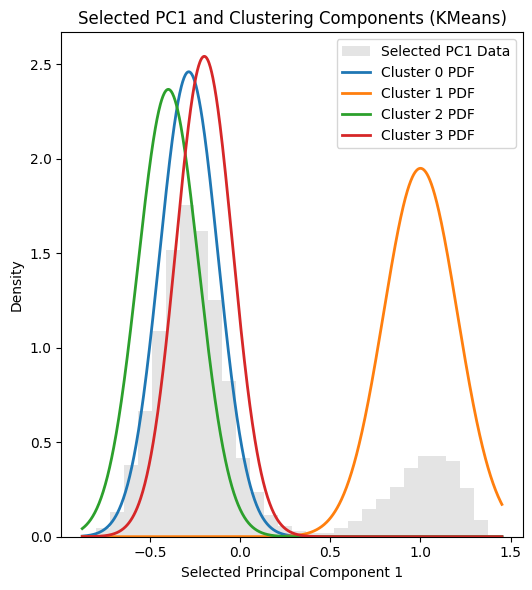

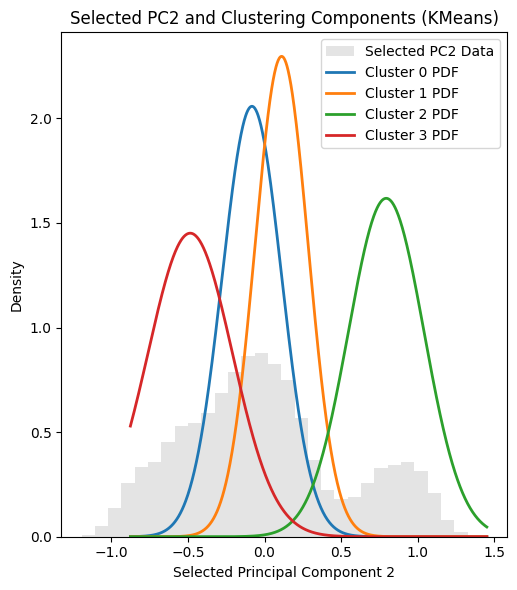

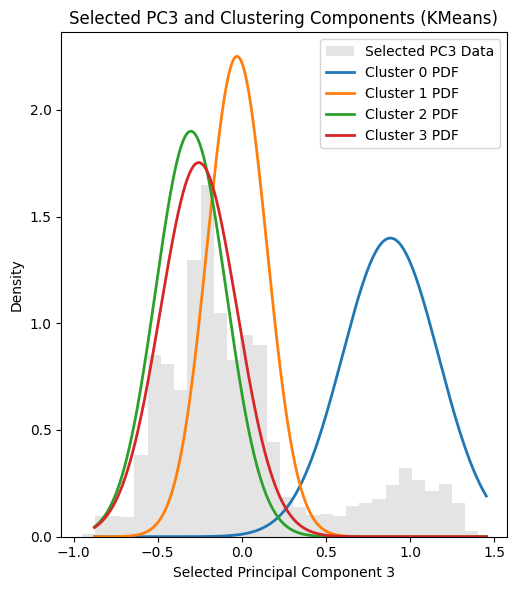

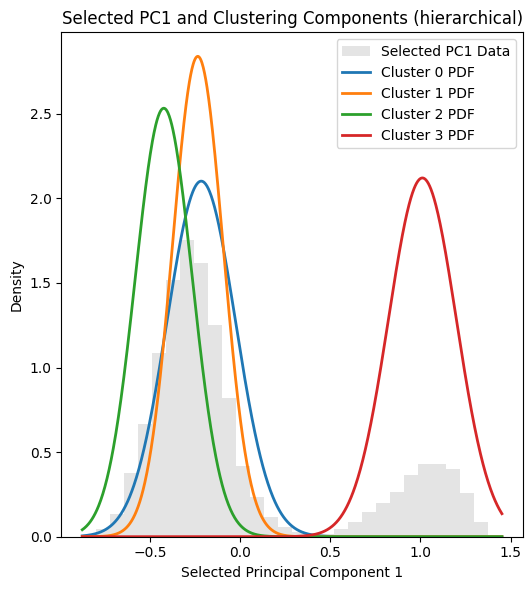

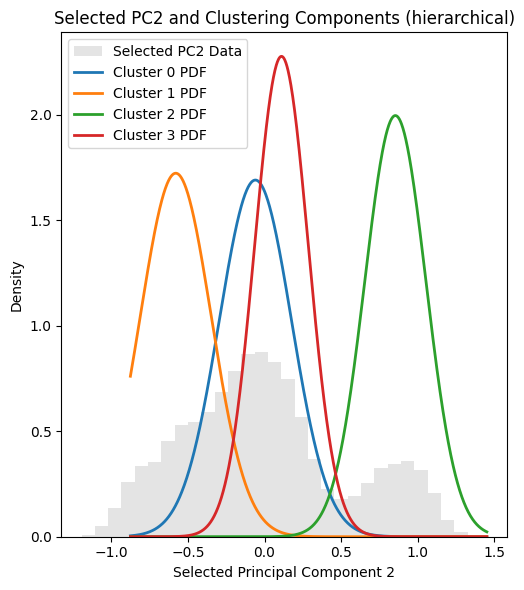

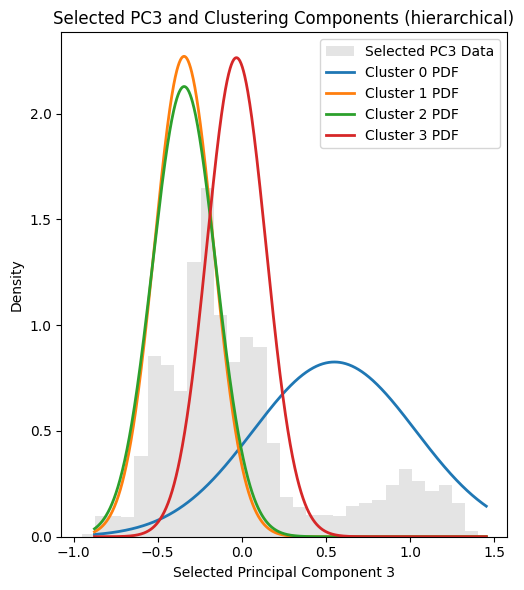

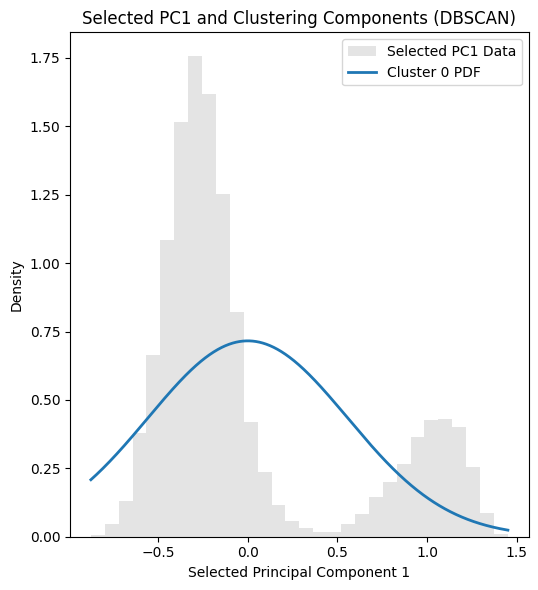

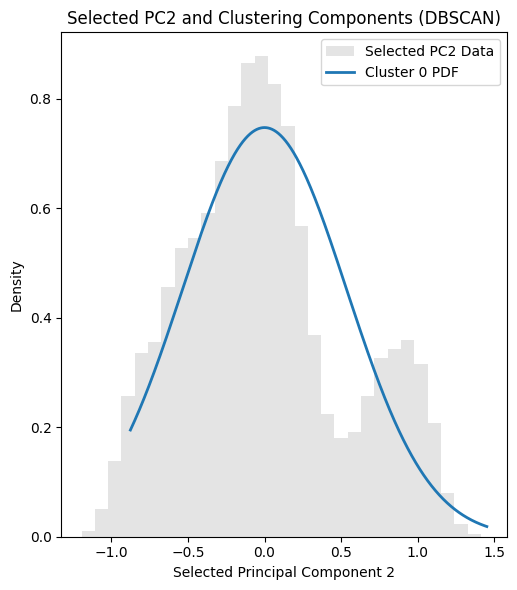

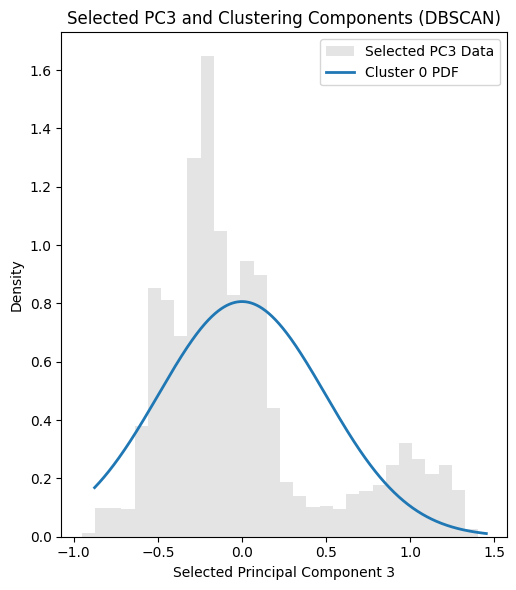

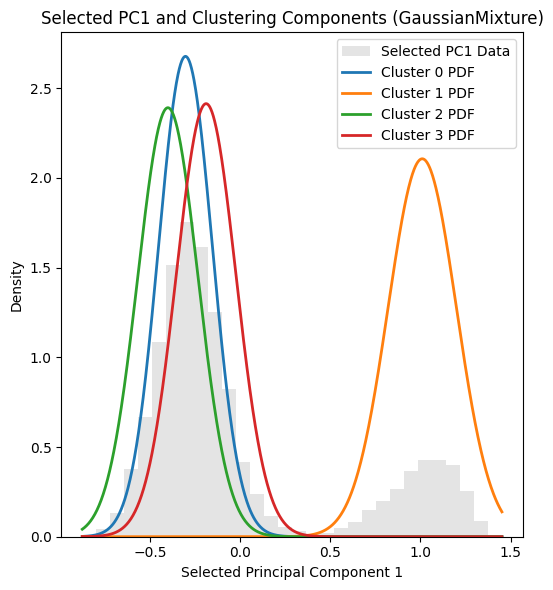

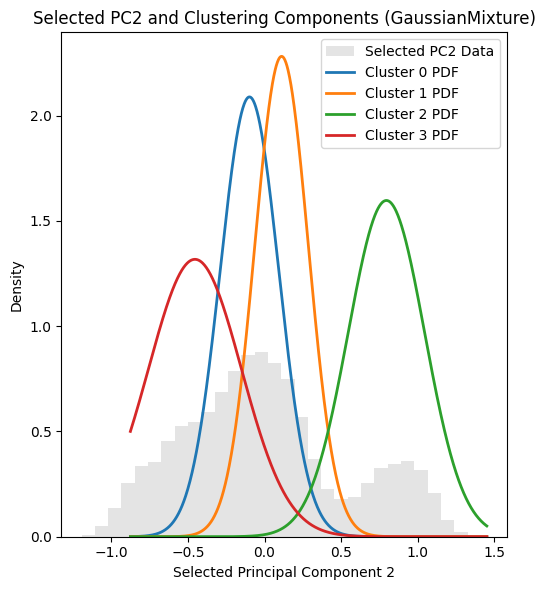

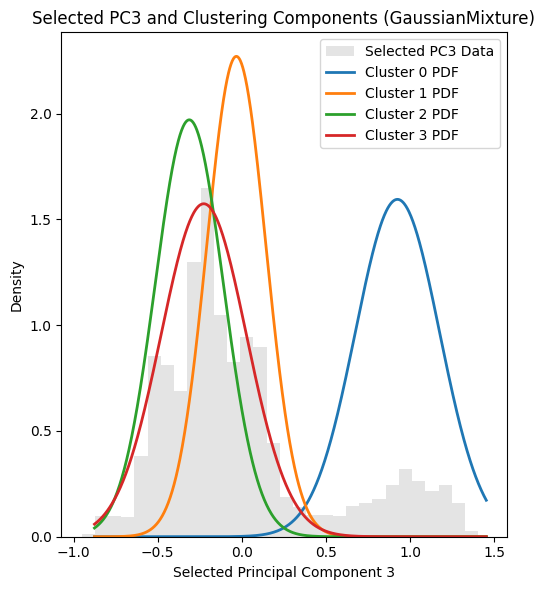

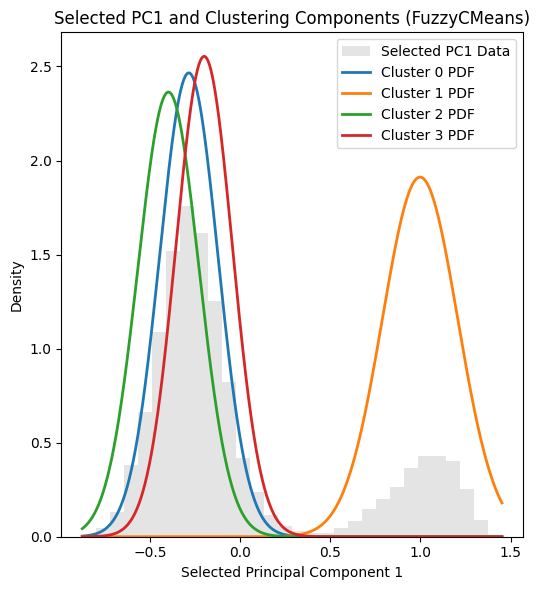

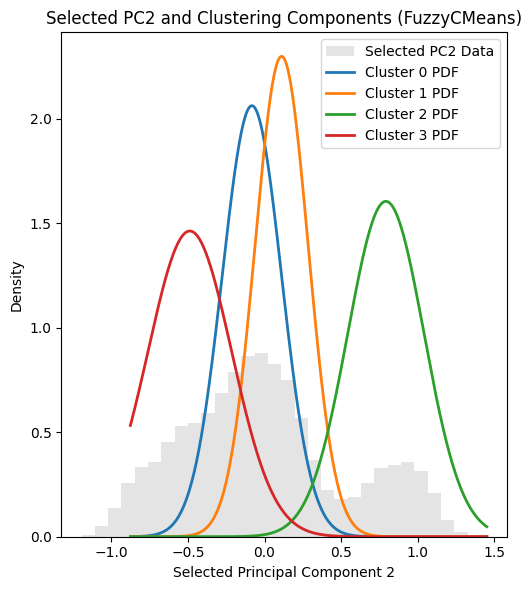

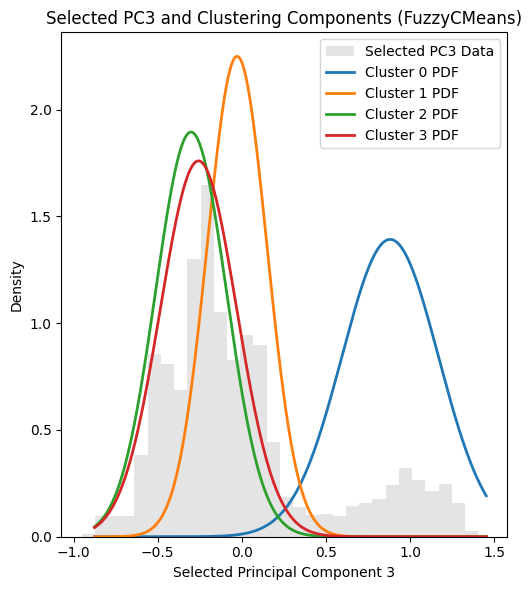

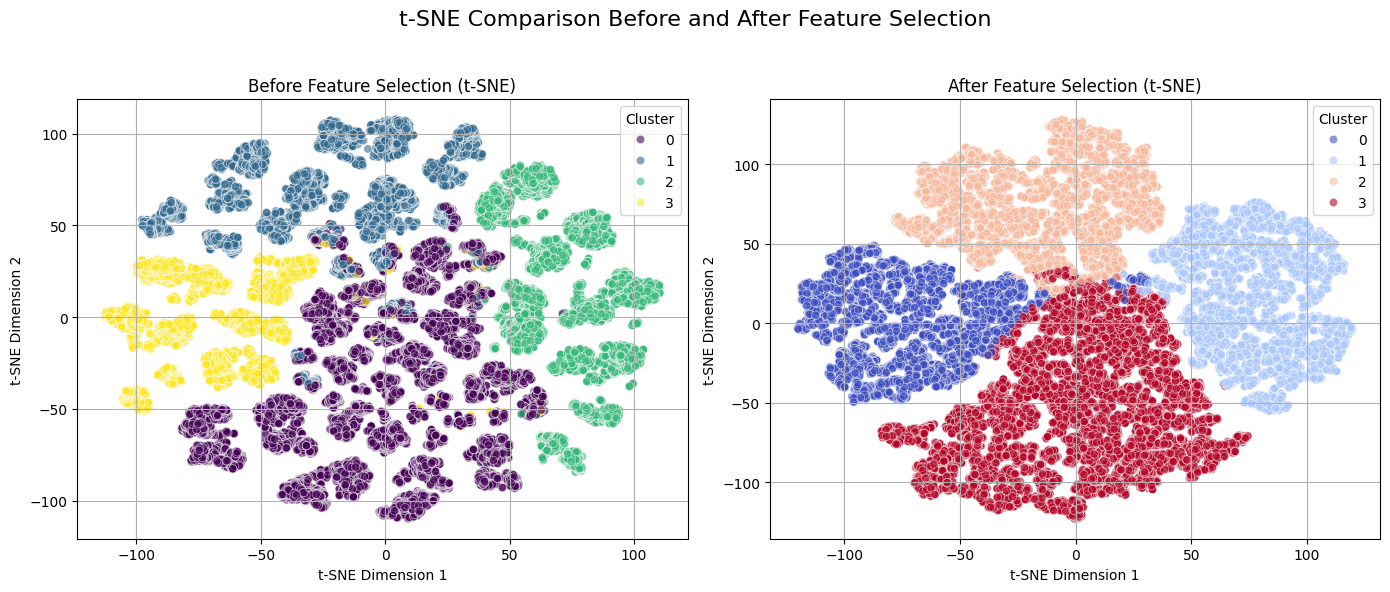

K-means Davies-Bouldin Index: 0.54073
GMM Davies-Bouldin Index: 0.55255
Fuzzy C-Means Davies-Bouldin Index: 0.53996


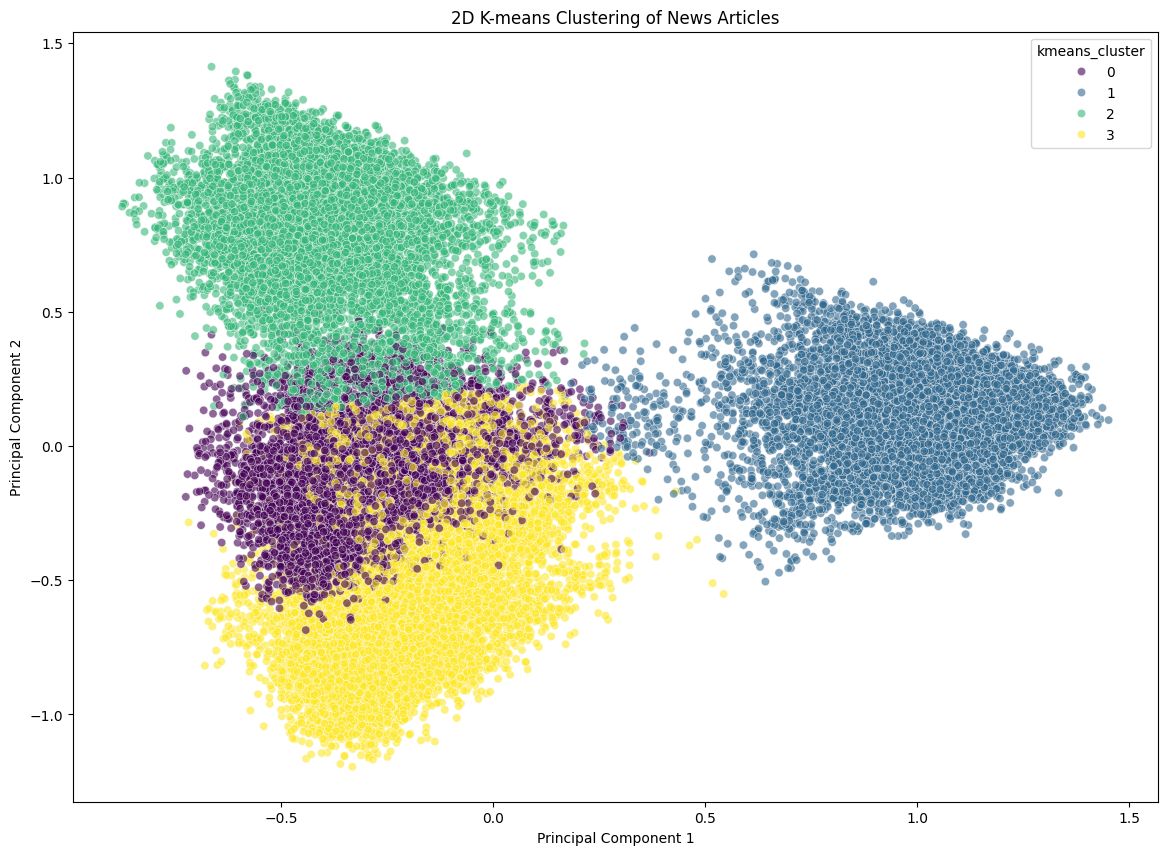

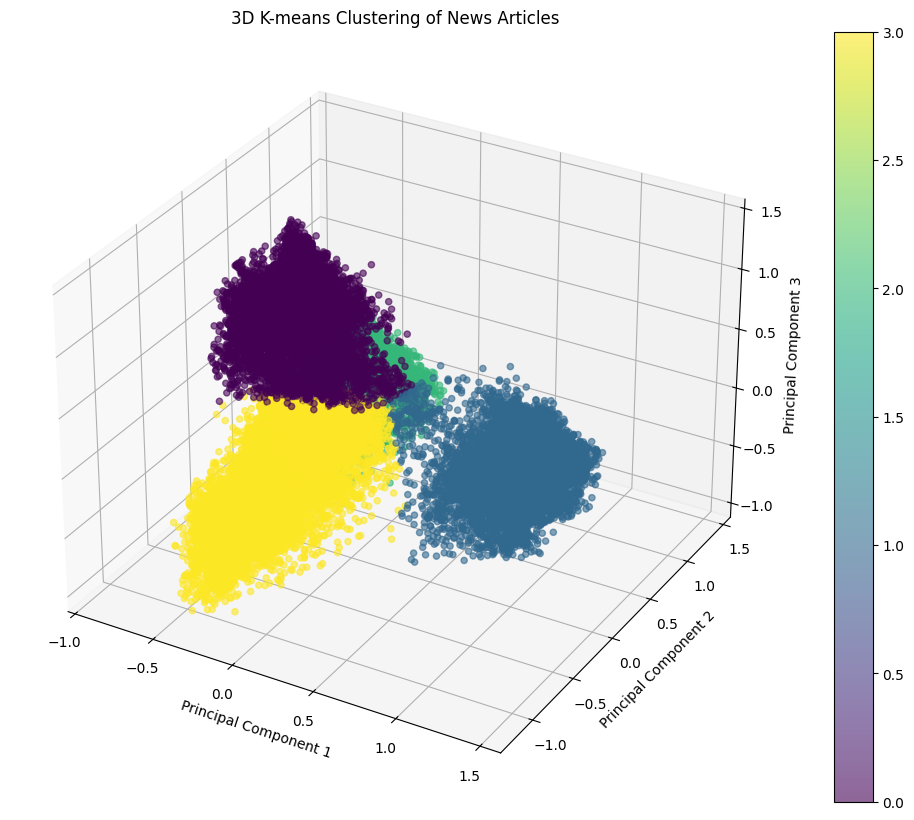

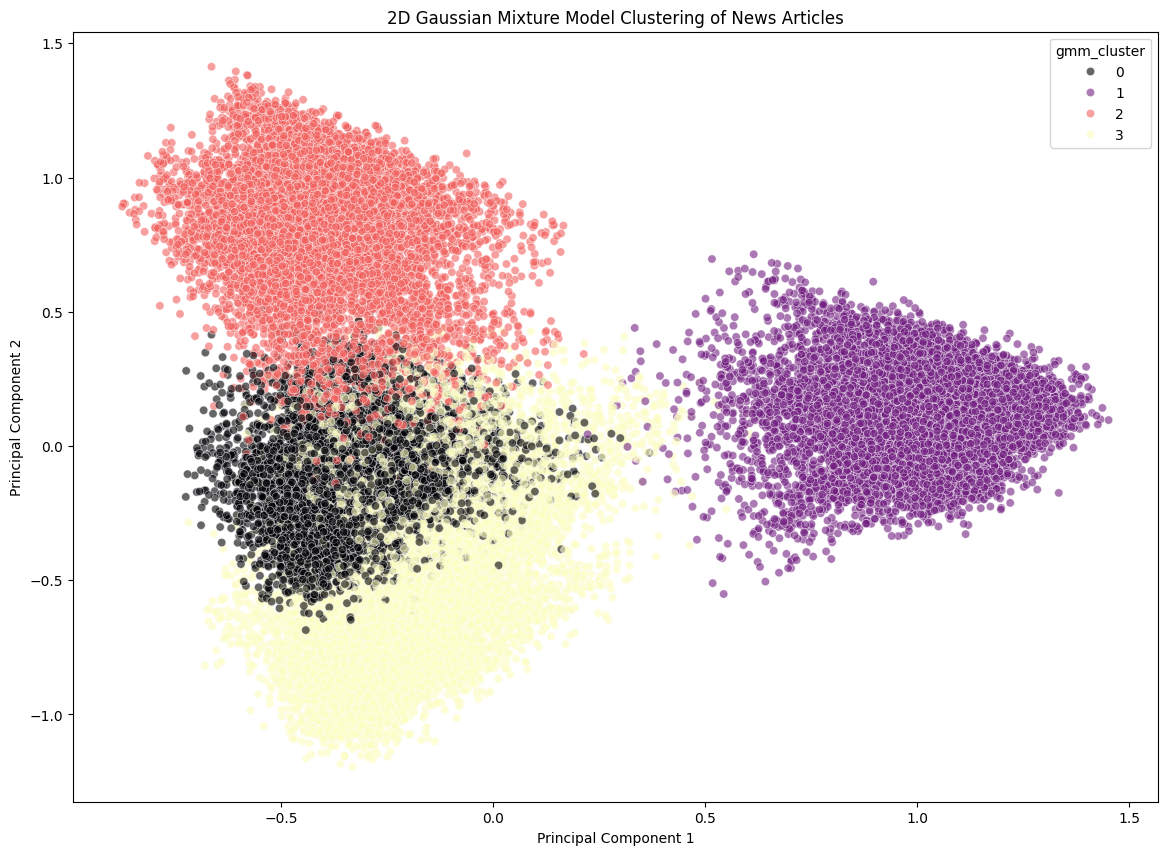

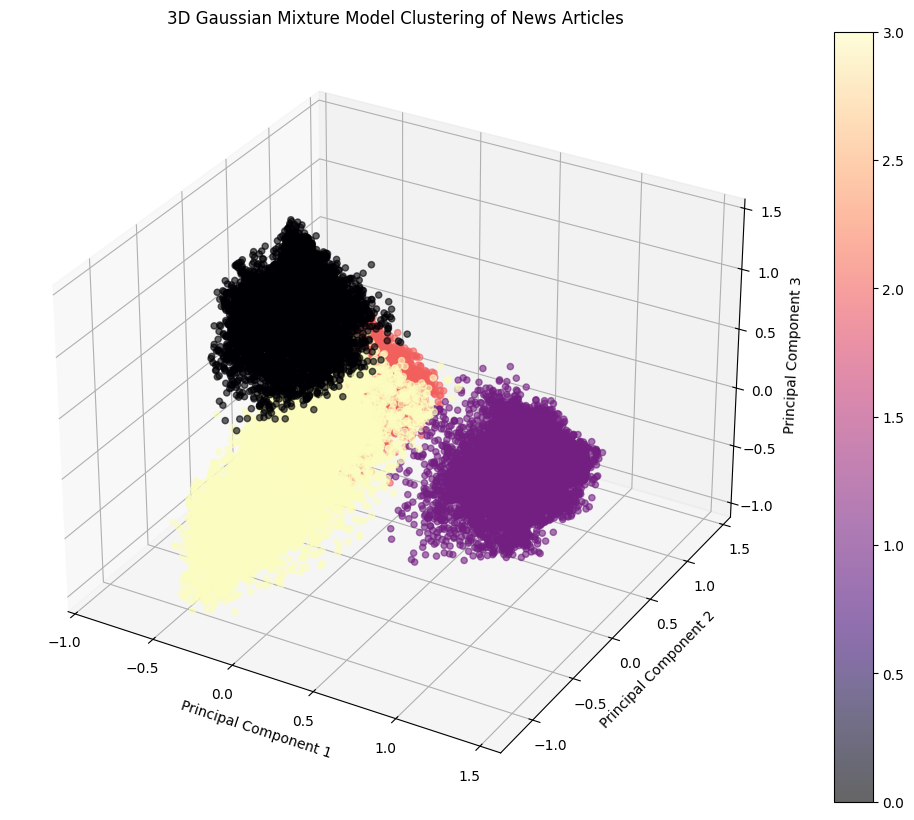

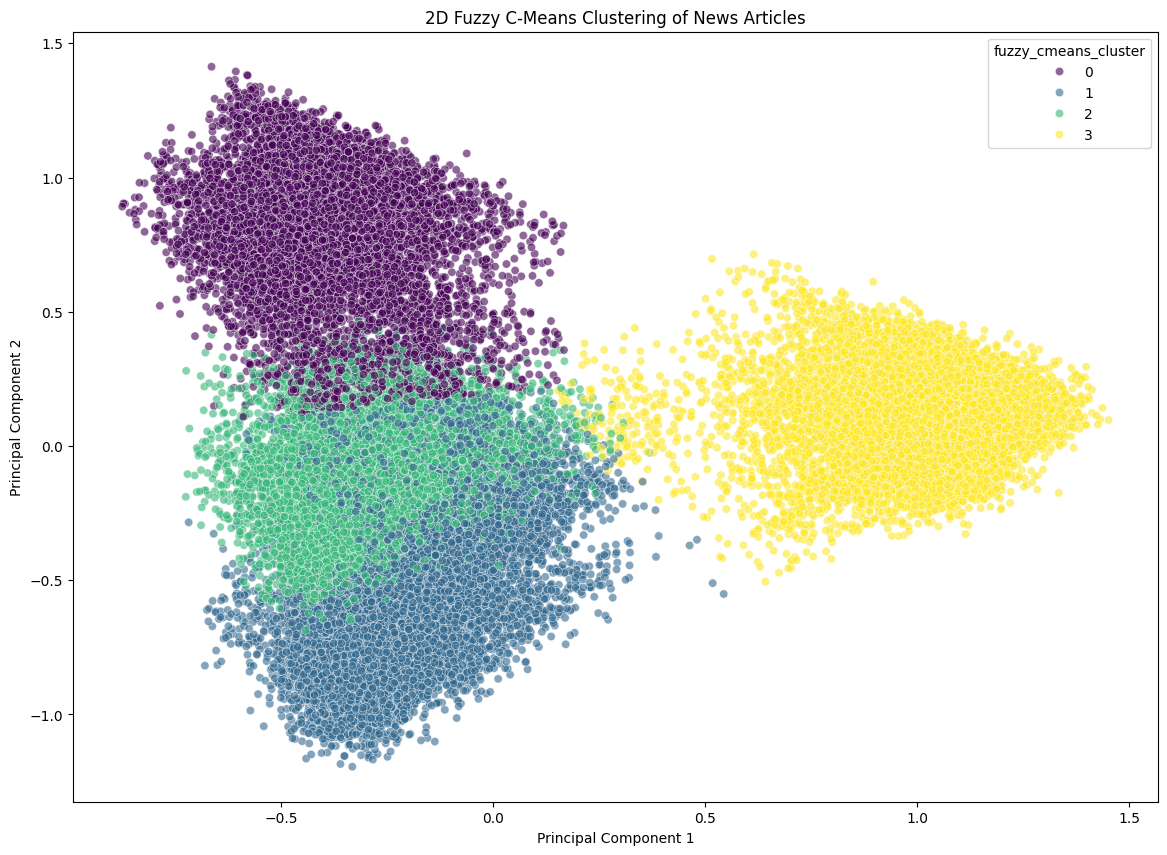

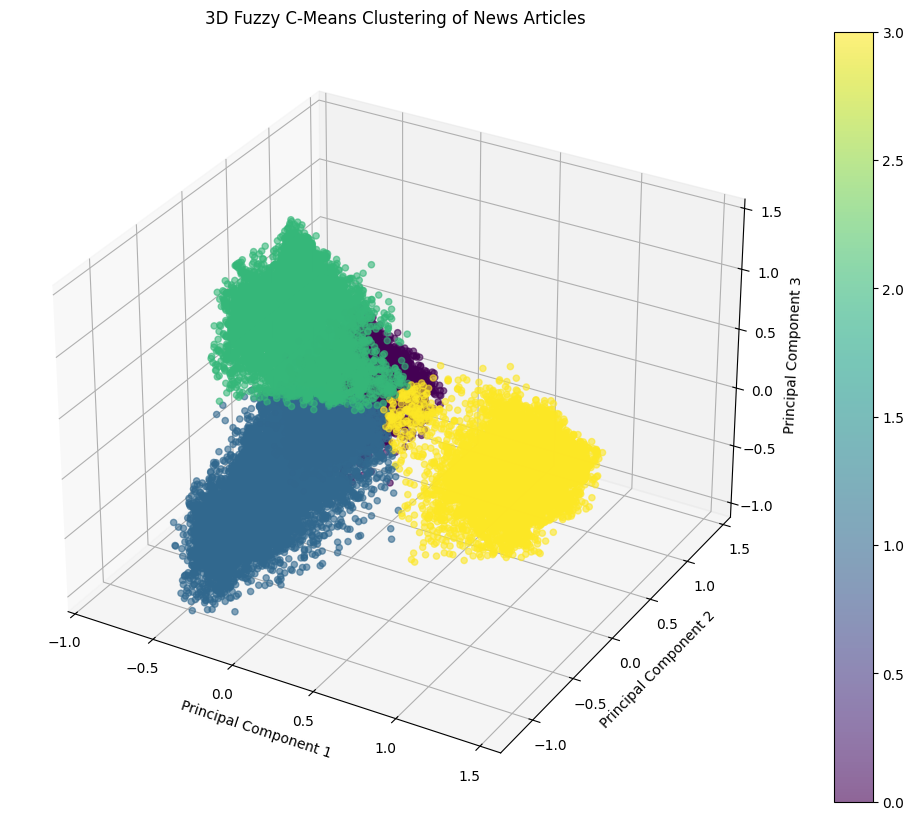

In [ ]:
# region imports og config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler  # Normalization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from minisom import MiniSom  # Self-Organizing Map
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz  # Fuzzy C-Means Clustering
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

N_CLUSTERS = 4

df = pd.read_csv(os.path.join('..', '..', 'data', 'Social-media', 'OnlineNewsPopularity.csv'))
# endregion

# region preprocess 

# Drop missing values if any
df = df.dropna()

# Select relevant numerical columns for clustering
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Normalize the features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[numeric_cols])

# endregion

# region extraction
# Step 3: Dimensionality Reduction (show cumulative variance before selecting components)
pca = PCA()
pca_fit = pca.fit(df_normalized)
explained_variance = np.cumsum(pca_fit.explained_variance_ratio_)

# Plot cumulative variance explained by PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select enough components to retain at least 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1  # Add 1 because of 0-based indexing
pca = PCA(n_components=n_components)
pca_fit = pca.fit(df_normalized)
reduced_data = pca.transform(df_normalized)

print(f'Selected {n_components} components to retain at least 95% of the variance.')
# endregion

# region selection
def filter_feature_selection(data, n_clusters, percentile=0.75):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    mi_scores = mutual_info_classif(data, labels, discrete_features=False)
    threshold_score = np.percentile(mi_scores, percentile * 100)
    print(f"Threshold score at {percentile*100}% percentile: {threshold_score:.2f}")
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(mi_scores)), mi_scores, color='skyblue', edgecolor='black')
    plt.axhline(y=threshold_score, color='red', linestyle='--', label=f'Threshold (Percentile {percentile*100}%)')
    plt.xlabel('Feature Index')
    plt.ylabel('Mutual Information Score')
    plt.title('Mutual Information Scores for Features')
    plt.legend()
    plt.show()
    return [i for i, score in enumerate(mi_scores) if score >= threshold_score]

n_clusters = N_CLUSTERS
percentile = 0.9
selected_features = filter_feature_selection(reduced_data, n_clusters, percentile=percentile)
print(f"Selected feature indices: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")
reduced_data_selected = reduced_data[:, selected_features]
# endregion

# region sammenlikne davies bouldin
def evaluate_clustering_with_fuzzy(data, max_clusters=10):
    scores = {}
    for n_clusters in range(2, max_clusters + 1):
        print(f"\nEvaluating {n_clusters} clusters:")
        results = {}

        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        results['KMeans'] = davies_bouldin_score(data, kmeans_labels)

        # Gaussian Mixture
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels = gmm.fit_predict(data)
        results['GaussianMixture'] = davies_bouldin_score(data, gmm_labels)

        # Fuzzy C-Means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data.T, c=n_clusters, m=2, error=1e-5, maxiter=1000, init=None
        )
        fuzzy_labels = np.argmax(u, axis=0)  # Get hard cluster assignments
        if len(set(fuzzy_labels)) > 1:  # Check to avoid calculation error with 1 unique cluster
            results['FuzzyCMeans'] = davies_bouldin_score(data, fuzzy_labels)
        else:
            results['FuzzyCMeans'] = np.nan  # Handle case with no meaningful clustering

        print(f"Cluster Size {n_clusters}: {results}")
        scores[n_clusters] = results

    return scores


# Evaluate clustering performance on selected features
cluster_scores = evaluate_clustering_with_fuzzy(reduced_data_selected, max_clusters=10)

# Visualize performance scores
for method in ['KMeans', 'GaussianMixture', 'FuzzyCMeans']:
    plt.plot(
        list(cluster_scores.keys()), 
        [cluster_scores[k][method] for k in cluster_scores.keys()],
        label=method
    )
    
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Clustering Performance Across Different Cluster Sizes')
plt.legend()
plt.grid()
plt.show()
# endregion

# region gaussian-pca greier
def fuzzy_cmeans_clustering(data, c=N_CLUSTERS, m=2, error=1e-5, maxiter=1000):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, c=c, m=m, error=error, maxiter=maxiter, init=None
    )
    # Get the cluster labels by finding the index of the maximum membership value for each data point
    labels = np.argmax(u, axis=0)
    return labels, cntr

models = {
    "KMeans": KMeans(n_clusters=N_CLUSTERS, random_state=42).fit(reduced_data_selected),
    "hierarchical": AgglomerativeClustering(n_clusters=N_CLUSTERS).fit(reduced_data_selected),
    "DBSCAN": DBSCAN(eps=100, min_samples=1).fit(reduced_data_selected),
    "GaussianMixture": GaussianMixture(n_components=N_CLUSTERS, random_state=42).fit(reduced_data_selected),
    # "som": MiniSom(x=10, y=10, input_len=reduced_data_selected.shape[1], sigma=1.0, learning_rate=0.5), # funka dårlig med de greiene her, ga også rar clustering, så ga f i den
    "FuzzyCMeans": fuzzy_cmeans_clustering(reduced_data_selected)
}

def plot_pca_with_gaussian(models, reduced_data, n_components=3):
    x = np.linspace(reduced_data[:, 0].min(), reduced_data[:, 0].max(), 1000)

    for model_name, model in models.items():
        if model_name == "FuzzyCMeans":
            labels, _ = model  # Unpack the labels and centroids from the fuzzy c-means clustering
        else:
            if hasattr(model, 'labels_'):  # For models like AgglomerativeClustering that don't have a predict method
                labels = model.labels_
            else:
                # Use predict method for models that have it (e.g., KMeans, GaussianMixture)
                labels = model.predict(reduced_data)

        # Plot for the first three selected principal components
        for i in range(min(n_components, reduced_data.shape[1])):
            plt.figure(figsize=(15, 6))
            ax = plt.subplot(1, 3, i + 1)

            # Histogram of data along the i-th principal component
            ax.hist(reduced_data[:, i], bins=30, density=True, alpha=0.6, label=f'Selected PC{i+1} Data', color='lightgray')

            # Plot Gaussian distribution for each cluster
            for cluster in np.unique(labels):
                cluster_data = reduced_data[labels == cluster, i]  # Select the i-th column for the current cluster
                mean = np.mean(cluster_data)
                std_dev = np.std(cluster_data)
                pdf = norm.pdf(x, mean, std_dev)
                ax.plot(x, pdf, label=f'Cluster {cluster} PDF', lw=2)

            ax.set_title(f'Selected PC{i+1} and Clustering Components ({model_name})')
            ax.set_xlabel(f'Selected Principal Component {i+1}')
            ax.set_ylabel('Density')
            ax.legend()

            plt.tight_layout()
            plt.show()

# Example of usage:
plot_pca_with_gaussian(models, reduced_data_selected, n_components=3)

# endregion

# region tsne, visualisere selection
# Visualization: t-SNE Comparison Before and After Feature Selection
def plot_tsne_comparison(data_full, labels_full, data_selected, labels_selected, title):
    """
    Visualize clustering structure before and after feature selection using t-SNE.

    Parameters:
    - data_full: np.ndarray, full PCA data
    - labels_full: np.ndarray, cluster labels for full data
    - data_selected: np.ndarray, data after feature selection
    - labels_selected: np.ndarray, cluster labels for selected data
    - title: str, overall title for the plot
    """
    tsne_full = TSNE(n_components=2, random_state=42).fit_transform(data_full)
    tsne_selected = TSNE(n_components=2, random_state=42).fit_transform(data_selected)

    plt.figure(figsize=(14, 6))

    # t-SNE for full data
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=tsne_full[:, 0],
        y=tsne_full[:, 1],
        hue=labels_full,
        palette="viridis",
        alpha=0.6,
    )
    plt.title("Before Feature Selection (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.grid()

    # t-SNE for selected data
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_selected[:, 0],
        y=tsne_selected[:, 1],
        hue=labels_selected,
        palette="coolwarm",
        alpha=0.6,
    )
    plt.title("After Feature Selection (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.grid()

    # Add a main title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Perform clustering on full PCA data
kmeans_full = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit(reduced_data)
labels_full = kmeans_full.labels_

# Perform clustering on selected features
kmeans_selected = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit(reduced_data_selected)
labels_selected = kmeans_selected.labels_

# Plot the comparison
plot_tsne_comparison(
    reduced_data,
    labels_full,
    reduced_data_selected,
    labels_selected,
    "t-SNE Comparison Before and After Feature Selection"
)
# endregion

# region algos
# **Algorithm 1: K-means Clustering**
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate K-means clustering using Davies-Bouldin Index
kmeans_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['kmeans_cluster'])
print(f'K-means Davies-Bouldin Index: {kmeans_davies_bouldin:.5f}')

# **Algorithm 2: Hierarchical Clustering**
# hierarchical = AgglomerativeClustering(n_clusters=N_CLUSTERS)
# df['hierarchical_cluster'] = hierarchical.fit_predict(reduced_data_selected[:, :3])

# # Evaluate Hierarchical clustering using Davies-Bouldin Index
# hierarchical_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['hierarchical_cluster'])
# print(f'Hierarchical Davies-Bouldin Index: {hierarchical_davies_bouldin:.5f}')

# **Algorithm 3: DBSCAN Clustering**
# dbscan = DBSCAN(eps=100, min_samples=1)
# df['dbscan_cluster'] = dbscan.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# # Evaluate DBSCAN clustering using Davies-Bouldin Index (only if clusters are found)
# if len(set(df['dbscan_cluster'])) > 1:
#     dbscan_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['dbscan_cluster'])
#     print(f'DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin:.5f}')
# else:
#     print('DBSCAN did not find any clusters (only noise).')

# **Algorithm 4: Gaussian Mixture Model (GMM)**
gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate GMM clustering using Davies-Bouldin Index
gmm_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['gmm_cluster'])
print(f'GMM Davies-Bouldin Index: {gmm_davies_bouldin:.5f}')

# **Algorithm 5: Self-Organizing Map (SOM)**
# som = MiniSom(x=10, y=10, input_len=reduced_data_selected.shape[1], sigma=1.0, learning_rate=0.5)
# som.train(reduced_data_selected, 5, verbose=True)

# # Get the winning neuron for each data point
# winning_positions = np.array([som.winner(data) for data in reduced_data_selected])
# df['som_cluster'] = [pos[0] * 10 + pos[1] for pos in winning_positions]

# # **Algorithm 6: Fuzzy C-Means Clustering**
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(reduced_data_selected.T, c=N_CLUSTERS, m=2, error=1e-5, maxiter=1000, init=None)

# Assign cluster labels to the DataFrame
df['fuzzy_cmeans_cluster'] = np.argmax(u, axis=0)

# Evaluate Fuzzy C-Means clustering using Davies-Bouldin Index
if len(set(df['fuzzy_cmeans_cluster'])) > 1:
    fuzzy_cmeans_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['fuzzy_cmeans_cluster'])
    print(f'Fuzzy C-Means Davies-Bouldin Index: {fuzzy_cmeans_davies_bouldin:.5f}')
else:
    print('Fuzzy C-Means did not find any clusters (only noise).')
# endregion

# region plotting
# 2D K-means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['kmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D K-means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# # 2D Hierarchical plot
# plt.figure(figsize=(14, 10))
# sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['hierarchical_cluster'], palette='viridis', alpha=0.6)
# plt.title('2D Hierarchical Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # 3D Hierarchical plot
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['hierarchical_cluster'], cmap='plasma', alpha=0.6)
# plt.title('3D Hierarchical Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.colorbar(sc)
# plt.show()

# # 2D DBSCAN plot
# plt.figure(figsize=(14, 10))
# sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['dbscan_cluster'], palette='coolwarm', alpha=0.6)
# plt.title('2D DBSCAN Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # 3D DBSCAN plot
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['dbscan_cluster'], cmap='coolwarm', alpha=0.6)
# plt.title('3D DBSCAN Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.colorbar(sc)
# plt.show()

# 2D GMM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['gmm_cluster'], palette='magma', alpha=0.6)
plt.title('2D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D GMM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['gmm_cluster'], cmap='magma', alpha=0.6)
plt.title('3D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# # 2D SOM plot
# plt.figure(figsize=(14, 10))
# sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['som_cluster'], palette='viridis', alpha=0.6)
# plt.title('2D SOM Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # 3D SOM plot
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['som_cluster'], cmap='viridis', alpha=0.6)
# plt.title('3D SOM Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.colorbar(sc)
# plt.show()

# 2D Fuzzy C-Means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['fuzzy_cmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Fuzzy C-Means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['fuzzy_cmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()
# endregion 


Evaluating 2 clusters:
Cluster Size 2: {'KMeans': np.float64(0.8213757001194913), 'GaussianMixture': np.float64(0.8211576487114006), 'FuzzyCMeans': np.float64(1.0185951544318885)}

Evaluating 3 clusters:
Cluster Size 3: {'KMeans': np.float64(0.7448100989663202), 'GaussianMixture': np.float64(0.7510283743982596), 'FuzzyCMeans': np.float64(0.7868503659986663)}

Evaluating 4 clusters:
Cluster Size 4: {'KMeans': np.float64(0.540725377924433), 'GaussianMixture': np.float64(0.5525475542742004), 'FuzzyCMeans': np.float64(0.5399624802207751)}

Evaluating 5 clusters:
Cluster Size 5: {'KMeans': np.float64(0.6933416389287498), 'GaussianMixture': np.float64(0.8201289916969886), 'FuzzyCMeans': np.float64(0.6931098706910873)}

Evaluating 6 clusters:
Cluster Size 6: {'KMeans': np.float64(0.8810275490479512), 'GaussianMixture': np.float64(0.9920029153667415), 'FuzzyCMeans': np.float64(0.798866525307376)}

Evaluating 7 clusters:
Cluster Size 7: {'KMeans': np.float64(1.012271882000101), 'GaussianMixtur

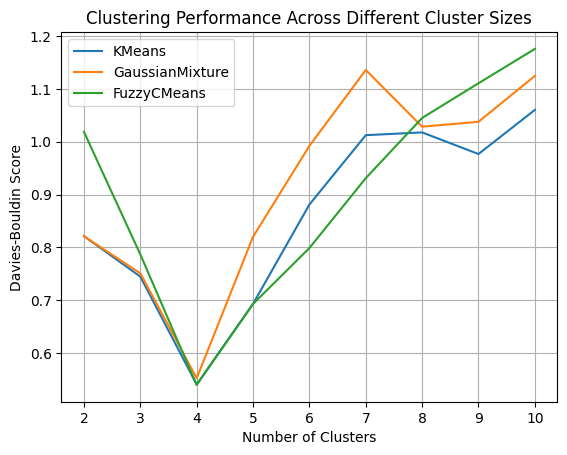

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

def evaluate_clustering_with_fuzzy(data, max_clusters=10):
    scores = {}
    for n_clusters in range(2, max_clusters + 1):
        print(f"\nEvaluating {n_clusters} clusters:")
        results = {}

        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        results['KMeans'] = davies_bouldin_score(data, kmeans_labels)

        # Gaussian Mixture
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels = gmm.fit_predict(data)
        results['GaussianMixture'] = davies_bouldin_score(data, gmm_labels)

        # Fuzzy C-Means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data.T, c=n_clusters, m=2, error=1e-5, maxiter=1000, init=None
        )
        fuzzy_labels = np.argmax(u, axis=0)  # Get hard cluster assignments
        if len(set(fuzzy_labels)) > 1:  # Check to avoid calculation error with 1 unique cluster
            results['FuzzyCMeans'] = davies_bouldin_score(data, fuzzy_labels)
        else:
            results['FuzzyCMeans'] = np.nan  # Handle case with no meaningful clustering

        print(f"Cluster Size {n_clusters}: {results}")
        scores[n_clusters] = results

    return scores


# Evaluate clustering performance on selected features
cluster_scores = evaluate_clustering_with_fuzzy(reduced_data_selected, max_clusters=10)

# Visualize performance scores
for method in ['KMeans', 'GaussianMixture', 'FuzzyCMeans']:
    plt.plot(
        list(cluster_scores.keys()), 
        [cluster_scores[k][method] for k in cluster_scores.keys()],
        label=method
    )
    
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Clustering Performance Across Different Cluster Sizes')
plt.legend()
plt.grid()
plt.show()
